In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Suicide_Detection.csv', engine='python')


In [3]:
#Cambiamos la clase a dummy y achicamos el dataset para poder entrenarlo


In [4]:
df = pd.get_dummies(df, columns = ['class'], drop_first = True)

In [5]:
df = df.iloc[:,1:]

In [6]:
df = df.iloc[220000:]


In [7]:
df.shape

(12074, 2)

In [8]:
#Importamos librerias para trabajar sobre text mining
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Defining Features Matrix
X = df.drop(['class_suicide'], axis=1)
X.head()

,text
220000,My inability to sleep... ...It is frightening....
220001,I just woke up at 2 pm hows your day going?
220002,I want more snap streaks so I can see cute boi...
220003,I read an interesting article on notesI starte...
220004,The horrors of the climbing unit in Gym class ...


In [10]:
# Define Target
y = df['class_suicide']
y.head()

220000    0
220001    0
220002    0
220003    1
220004    0
Name: class_suicide, dtype: uint8

In [11]:
# Separate training and testing sets, stratifying by class
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [12]:
#Vamos a limpiar los datos de train y test
#Usamos Tokennizer que elimine los signos de puntuación y tags html
#Hacemos stemming para obtener las raices de las palabras en minusculas
#Eliminamos stopwords

In [13]:
def clean_reddit(text, tokenizer, stemmer, stopwords):
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(text)
    
    #Stemming : raiz y minusculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    #eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [14]:
#Importing for stepwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Equipo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#Eliminamos signos de puntuacion

tokenizer = RegexpTokenizer(r"\w+")

englishStemmer = SnowballStemmer("english")
stopwords_en = stopwords.words('english')
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

In [16]:
clean_train = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_train.text]

In [17]:
clean_test = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_test.text]

In [18]:
#CountVectorizer para transformar los datos de train y test

count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [19]:
X_train = pd.DataFrame(X_train_sparse.todense(), 
             columns = count_vectorizer.get_feature_names())

In [20]:
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 

In [21]:
#Entrenamos KNN

In [22]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

In [23]:
#Creating Function for Cross Validation

def scores_knn(X, y, start,stop,step):
    
    # We are going to graph the different values of the cross validation score based on the n_neighbors hyperparameter
    # For this we are going to generate a list of dictionaries that can then be easily converted into a DataFrame
    
    # List of dictionaries - we initialize it empty and outside the for loop to feed it in each iteration
    scores_for_df = []
    
    
    for i in range(start,stop,step):
        
        # At each iteration, we instantiate the model with a different hyperparameter
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores returns an array of 5 results, one for each partition that CV automatically made
        kf = KFold(n_splits=10, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # For each value of n_neighbours, we create a dictionary with the value of n_neighbours and the mean and deviation of the scores
        dict_row_score = {'medium_score':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # We save each one in the list of dictionaries
        scores_for_df.append(dict_row_score)
    
    # We create the DF from the list of results
    df_scores = pd.DataFrame(scores_for_df)
    
    # We incorporate the lower and upper limits, subtracting and adding the value of the standard deviation, respectively
    df_scores['lower_limit'] = df_scores['medium_score'] - df_scores['score_std']
    df_scores['upper_limit'] = df_scores['medium_score'] + df_scores['score_std']
    
    # Return DF
    return df_scores

In [24]:
# CV for 1 to 20 neighbors
df_scores= scores_knn(X_train, y_train, 1, 21, 1)

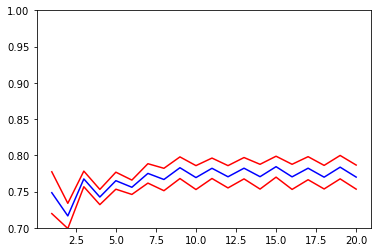

In [25]:
# viewing the results

plt.plot(df_scores['n_neighbours'], df_scores['lower_limit'], color='r')
plt.plot(df_scores['n_neighbours'], df_scores['medium_score'], color='b')
plt.plot(df_scores['n_neighbours'], df_scores['upper_limit'], color='r')
plt.ylim(0.7, 1);

In [26]:
df_scores

,medium_score,score_std,n_neighbours,lower_limit,upper_limit
0,0.748433,0.028835,1,0.719597,0.777268
1,0.716403,0.017392,2,0.699011,0.733794
2,0.767425,0.010789,3,0.756636,0.778213
3,0.742464,0.010495,4,0.731969,0.752959
4,0.764992,0.011744,5,0.753248,0.776736
5,0.755937,0.009895,6,0.746042,0.765831
6,0.775043,0.013384,7,0.761659,0.788427
7,0.766650,0.015449,8,0.751201,0.782100
8,0.782883,0.014937,9,0.767946,0.797820
9,0.769300,0.016491,10,0.752809,0.785792


In [27]:
#Identifying the maximum score
df_scores.loc[df_scores.medium_score == df_scores.medium_score.max()]

,medium_score,score_std,n_neighbours,lower_limit,upper_limit
14,0.784319,0.014429,15,0.76989,0.798749


In [28]:
# Assigning the value of optimal k to a variable
best_k = df_scores.loc[df_scores.medium_score == df_scores.medium_score.max(),'n_neighbours'].values[0]
best_k

15

In [29]:
# Choosing the optimal model that cross validation had indicated
model = KNeighborsClassifier(n_neighbors=best_k)

# Fitting on training data
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [30]:
from sklearn.metrics import accuracy_score

#  Evaluatingn accuracy on train
accuracy_score(y_train, model.predict(X_train))

0.82263942573164

In [31]:
# Predicting on test
y_pred = model.predict(X_test)

In [32]:
# Evaluatingn accuracy on test
accuracy_score(y_test, y_pred)

0.7873468035773435

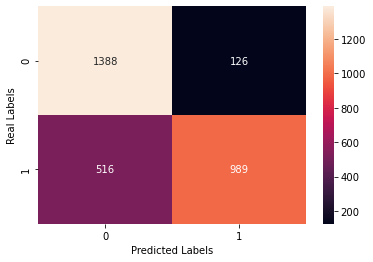

In [34]:
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.ylabel('Real Labels')
plt.xlabel('Predicted Labels');

In [35]:
#Clasification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1514
           1       0.89      0.66      0.75      1505

    accuracy                           0.79      3019
   macro avg       0.81      0.79      0.78      3019
weighted avg       0.81      0.79      0.78      3019



In [36]:
from sklearn.metrics import roc_curve

In [37]:
#Installing YellowBrick for multi class ROCAUC implementation
pip install yellowbrick

SyntaxError: invalid syntax (Temp/ipykernel_22512/2928699925.py, line 2)

In [38]:
from yellowbrick.classifier import ROCAUC

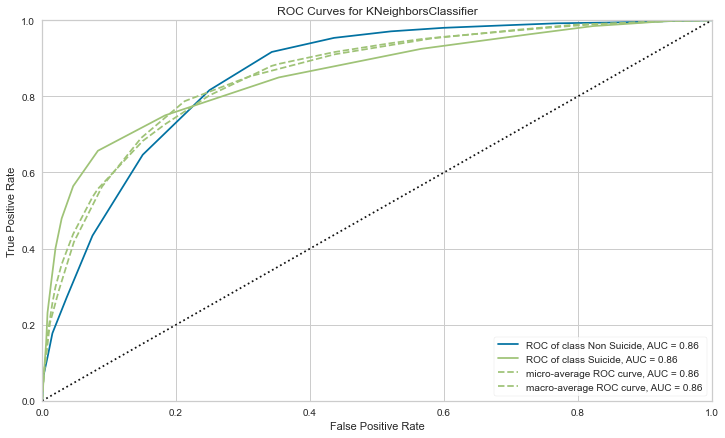

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
classes = ['Non Suicide','Suicide']
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(model, classes=classes, ax=ax)
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()